# 06 CNN 反向传播详解

> 深入理解 CNN 如何学习：从数学推导到代码实现

---

## 📚 学习目标

学完本章后，你将能够：

- [ ] 理解反向传播的数学原理（链式法则）
- [ ] 推导卷积层的梯度公式（对权重 W 和输入 X）
- [ ] 推导池化层的梯度传递规则
- [ ] 从零实现完整 CNN 的反向传播
- [ ] 在 MNIST 上训练自己实现的 CNN

## 🔍 前置知识

请确保已完成：
- ✅ 05_cnn_architecture.ipynb（CNN 各层的作用）
- ✅ 基础微积分（偏导数、链式法则）

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import warnings
warnings.filterwarnings('default')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)
print("环境准备完成！")

环境准备完成！


---

## 💡 1. 为什么需要反向传播？

### 1.1 神经网络的学习过程

神经网络学习 = 调整权重，使得预测越来越准确

```
学习循环：
1. 前向传播：输入 → 经过各层 → 得到预测
2. 计算损失：预测 vs 真实标签 → 差距有多大？
3. 反向传播：损失 → 逐层传回 → 计算每个权重的梯度
4. 更新权重：W_new = W_old - learning_rate × 梯度
5. 重复以上步骤
```

### 1.2 梯度下降回顾

**目标**：找到使损失函数 L 最小的权重 W

**方法**：沿着梯度的反方向更新权重

$$W_{new} = W_{old} - \eta \cdot \frac{\partial L}{\partial W}$$

其中：
- $\eta$ (eta)：学习率
- $\frac{\partial L}{\partial W}$：损失对权重的梯度

### 1.3 链式法则复习

当函数是复合函数时，求导需要用链式法则：

**单变量情况**：
$$\text{如果 } y = f(u), u = g(x) \text{，则 } \frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx}$$

**例子**：
$$y = (2x + 1)^2$$

令 $u = 2x + 1$，则 $y = u^2$

$$\frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx} = 2u \cdot 2 = 4(2x+1)$$

In [ ]:
# ============================================================
# 链式法则演示
# ============================================================

def demo_chain_rule():
    """
    演示链式法则在神经网络中的应用
    
    考虑一个简单的网络：
    x → [乘以 w1] → z1 → [乘以 w2] → z2 → [计算损失] → L
    
    前向传播：
    z1 = x * w1
    z2 = z1 * w2
    L = (z2 - target)^2
    
    反向传播（链式法则）：
    dL/dw2 = dL/dz2 * dz2/dw2
    dL/dw1 = dL/dz2 * dz2/dz1 * dz1/dw1
    """
    # 输入和目标
    x = 2.0
    target = 8.0
    
    # 权重
    w1 = 1.5
    w2 = 2.0
    
    # ========== 前向传播 ==========
    z1 = x * w1           # z1 = 2.0 * 1.5 = 3.0
    z2 = z1 * w2          # z2 = 3.0 * 2.0 = 6.0
    L = (z2 - target)**2  # L = (6.0 - 8.0)^2 = 4.0
    
    print("=" * 50)
    print("前向传播：")
    print(f"  x = {x}")
    print(f"  z1 = x * w1 = {x} * {w1} = {z1}")
    print(f"  z2 = z1 * w2 = {z1} * {w2} = {z2}")
    print(f"  L = (z2 - target)^2 = ({z2} - {target})^2 = {L}")
    
    # ========== 反向传播（链式法则） ==========
    # 从损失开始，逐层往回传
    
    # 第1步：dL/dz2
    # L = (z2 - target)^2，对 z2 求导
    dL_dz2 = 2 * (z2 - target)  # = 2 * (-2) = -4
    
    # 第2步：dL/dw2 = dL/dz2 * dz2/dw2
    # z2 = z1 * w2，对 w2 求导得 z1
    dz2_dw2 = z1
    dL_dw2 = dL_dz2 * dz2_dw2  # = -4 * 3.0 = -12
    
    # 第3步：dL/dz1 = dL/dz2 * dz2/dz1
    # z2 = z1 * w2，对 z1 求导得 w2
    dz2_dz1 = w2
    dL_dz1 = dL_dz2 * dz2_dz1  # = -4 * 2.0 = -8
    
    # 第4步：dL/dw1 = dL/dz1 * dz1/dw1
    # z1 = x * w1，对 w1 求导得 x
    dz1_dw1 = x
    dL_dw1 = dL_dz1 * dz1_dw1  # = -8 * 2.0 = -16
    
    print("\n" + "=" * 50)
    print("反向传播（链式法则）：")
    print(f"\n  第1步：dL/dz2 = 2*(z2-target) = 2*({z2}-{target}) = {dL_dz2}")
    print(f"  第2步：dL/dw2 = dL/dz2 * dz2/dw2 = {dL_dz2} * {dz2_dw2} = {dL_dw2}")
    print(f"  第3步：dL/dz1 = dL/dz2 * dz2/dz1 = {dL_dz2} * {dz2_dz1} = {dL_dz1}")
    print(f"  第4步：dL/dw1 = dL/dz1 * dz1/dw1 = {dL_dz1} * {dz1_dw1} = {dL_dw1}")
    
    print("\n" + "=" * 50)
    print("梯度汇总：")
    print(f"  dL/dw1 = {dL_dw1}")
    print(f"  dL/dw2 = {dL_dw2}")
    
    return dL_dw1, dL_dw2

demo_chain_rule()

### 1.4 计算图的概念

我们可以用**计算图**来可视化前向和反向传播：

```
前向传播（从左到右）：

  x ──────┐
          ├─→ [×] ──→ z1 ──────┐
  w1 ─────┘                    ├─→ [×] ──→ z2 ──→ [L] ──→ Loss
                     w2 ───────┘

反向传播（从右到左）：

  dL/dx ←──┐
           ├─← [×] ←── dL/dz1 ←──┐
  dL/dw1 ←─┘                     ├─← [×] ←── dL/dz2 ←── [L] ←── 1
                       dL/dw2 ←──┘
```

**关键洞察**：
- 前向传播：计算输出值
- 反向传播：从输出端开始，利用链式法则逐层计算梯度

---

## 📐 2. 卷积层梯度推导（详细版）

这是本章的核心内容，我们将逐步推导卷积层的反向传播公式。

### 2.1 问题设置

**前向传播**（回顾05章）：

$$Y[i, j] = \sum_{m=0}^{k_h-1} \sum_{n=0}^{k_w-1} X[i+m, j+n] \cdot W[m, n] + b$$

### 📋 符号说明

| 符号 | 含义 | 说明 |
|------|------|------|
| **X** | 输入特征图 | 形状 $(H, W)$，例如 28×28 的灰度图 |
| **W** | 卷积核（滤波器） | 形状 $(k_h, k_w)$，例如 3×3 的权重矩阵 |
| **Y** | 输出特征图 | 形状 $(H_{out}, W_{out})$，卷积运算的结果 |
| **b** | 偏置 | 一个标量，加到每个输出位置 |
| **i, j** | 输出位置索引 | $Y[i,j]$ 表示输出特征图的第 $i$ 行、第 $j$ 列 |
| **m, n** | 卷积核内部索引 | $W[m,n]$ 表示卷积核的第 $m$ 行、第 $n$ 列 |
| **k_h, k_w** | 卷积核尺寸 | 卷积核的高度和宽度，如 3×3 核则 $k_h=k_w=3$ |
| **H, W** | 输入尺寸 | 输入特征图的高度和宽度 |
| **H_out, W_out** | 输出尺寸 | 输出特征图的尺寸，$H_{out} = H - k_h + 1$ |

### 🎯 公式直观理解

```
输出 Y[i,j] 是怎么算出来的？

    输入 X                    卷积核 W              输出 Y
┌─────────────────┐        ┌───────────┐
│ · · · · · · · · │        │ W[0,0] W[0,1] W[0,2] │
│ · ┌─────────┐ · │        │ W[1,0] W[1,1] W[1,2] │     ┌─────┐
│ · │X[i+0,j+0]│ · │   ×    │ W[2,0] W[2,1] W[2,2] │  =  │Y[i,j]│
│ · │X[i+1,j+1]│ · │        └───────────┘     └─────┘
│ · │X[i+2,j+2]│ · │
│ · └─────────┘ · │
│ · · · · · · · · │
└─────────────────┘

Y[i,j] = X[i+0,j+0]·W[0,0] + X[i+0,j+1]·W[0,1] + X[i+0,j+2]·W[0,2]
       + X[i+1,j+0]·W[1,0] + X[i+1,j+1]·W[1,1] + X[i+1,j+2]·W[1,2]
       + X[i+2,j+0]·W[2,0] + X[i+2,j+1]·W[2,1] + X[i+2,j+2]·W[2,2]
       + b

即：Y[i,j] = Σ_m Σ_n X[i+m, j+n] · W[m,n] + b
```

**反向传播目标**：

已知上游梯度 $\frac{\partial L}{\partial Y}$（损失对输出的梯度），求：

1. $\frac{\partial L}{\partial W}$：权重梯度（用于更新权重）
2. $\frac{\partial L}{\partial X}$：输入梯度（用于传给前一层）
3. $\frac{\partial L}{\partial b}$：偏置梯度（用于更新偏置）

### 2.2 对权重 W 的梯度（逐步推导）

我们要求 $\frac{\partial L}{\partial W[m, n]}$，即损失 L 对权重 W 中每个元素的偏导数。

#### 第1步：应用链式法则

由于 $W[m, n]$ 通过影响所有 $Y[i, j]$ 来影响 L，我们有：

$$\frac{\partial L}{\partial W[m, n]} = \sum_{i} \sum_{j} \frac{\partial L}{\partial Y[i, j]} \cdot \frac{\partial Y[i, j]}{\partial W[m, n]}$$

#### 第2步：计算 $\frac{\partial Y[i,j]}{\partial W[m,n]}$

从前向传播公式：
$$Y[i, j] = \sum_{m'} \sum_{n'} X[i+m', j+n'] \cdot W[m', n'] + b$$

对 $W[m, n]$ 求偏导：
$$\frac{\partial Y[i, j]}{\partial W[m, n]} = X[i+m, j+n]$$

（只有当 $m' = m$ 且 $n' = n$ 时，求导结果非零）

#### 第3步：代入得到最终公式

$$\frac{\partial L}{\partial W[m, n]} = \sum_{i} \sum_{j} \frac{\partial L}{\partial Y[i, j]} \cdot X[i+m, j+n]$$

#### 第4步：惊人的发现！

仔细观察这个公式，它实际上是 **X 和 dL/dY 的卷积**！

$$\boxed{\frac{\partial L}{\partial W} = X * \frac{\partial L}{\partial Y}}$$

其中 $*$ 表示卷积操作。

/var/folders/lp/_34q95f139j8jppsz3tx5gyr0000gn/T/ipykernel_86517/2046445018.py:82: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  plt.tight_layout()
/var/folders/lp/_34q95f139j8jppsz3tx5gyr0000gn/T/ipykernel_86517/2046445018.py:82: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  plt.tight_layout()
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


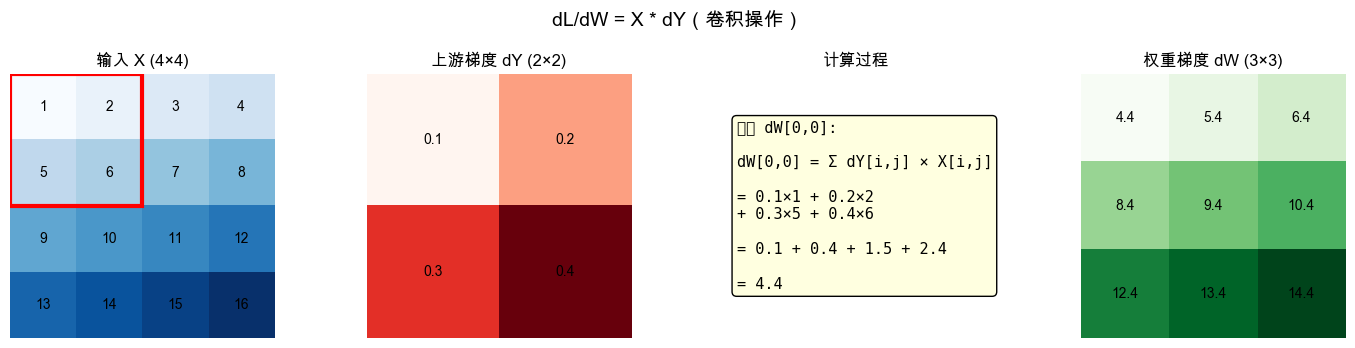


关键洞察：权重梯度 dW 是输入 X 和上游梯度 dY 的卷积！


In [8]:
# ============================================================
# 可视化：权重梯度的计算过程
# ============================================================

def visualize_dW_computation():
    """
    可视化 dL/dW 的计算过程
    
    dW[m, n] = Σ_i Σ_j dY[i,j] * X[i+m, j+n]
    这就是 X 和 dY 的卷积！
    """
    fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
    
    # 输入 X (4x4)
    X = np.array([
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ])
    
    # 上游梯度 dY (2x2)（假设 3x3 核，stride=1）
    dY = np.array([
        [0.1, 0.2],
        [0.3, 0.4]
    ])
    
    # 计算 dW[0,0]
    # dW[0,0] = dY[0,0]*X[0,0] + dY[0,1]*X[0,1] + dY[1,0]*X[1,0] + dY[1,1]*X[1,1]
    dW_00 = dY[0,0]*X[0,0] + dY[0,1]*X[0,1] + dY[1,0]*X[1,0] + dY[1,1]*X[1,1]
    
    # 绘制 X
    im0 = axes[0].imshow(X, cmap='Blues')
    axes[0].set_title('输入 X (4×4)', fontsize=12)
    for i in range(4):
        for j in range(4):
            axes[0].text(j, i, f'{X[i,j]}', ha='center', va='center', fontsize=10)
    # 高亮参与 dW[0,0] 计算的区域
    rect = plt.Rectangle((-0.5, -0.5), 2, 2, fill=False, edgecolor='red', linewidth=3)
    axes[0].add_patch(rect)
    axes[0].axis('off')
    
    # 绘制 dY
    im1 = axes[1].imshow(dY, cmap='Reds')
    axes[1].set_title('上游梯度 dY (2×2)', fontsize=12)
    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, f'{dY[i,j]:.1f}', ha='center', va='center', fontsize=10)
    axes[1].axis('off')
    
    # 绘制公式
    axes[2].axis('off')
    formula = (
        "计算 dW[0,0]:\n\n"
        f"dW[0,0] = Σ dY[i,j] × X[i,j]\n\n"
        f"= {dY[0,0]:.1f}×{X[0,0]} + {dY[0,1]:.1f}×{X[0,1]}\n"
        f"+ {dY[1,0]:.1f}×{X[1,0]} + {dY[1,1]:.1f}×{X[1,1]}\n\n"
        f"= {dY[0,0]*X[0,0]:.1f} + {dY[0,1]*X[0,1]:.1f} + {dY[1,0]*X[1,0]:.1f} + {dY[1,1]*X[1,1]:.1f}\n\n"
        f"= {dW_00:.1f}"
    )
    axes[2].text(0.1, 0.5, formula, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow'))
    axes[2].set_title('计算过程', fontsize=12)
    
    # 计算完整的 dW (3x3)
    dW = np.zeros((3, 3))
    for m in range(3):
        for n in range(3):
            for i in range(2):
                for j in range(2):
                    dW[m, n] += dY[i, j] * X[i+m, j+n]
    
    # 绘制 dW
    im3 = axes[3].imshow(dW, cmap='Greens')
    axes[3].set_title('权重梯度 dW (3×3)', fontsize=12)
    for i in range(3):
        for j in range(3):
            axes[3].text(j, i, f'{dW[i,j]:.1f}', ha='center', va='center', fontsize=10)
    axes[3].axis('off')
    
    plt.suptitle('dL/dW = X * dY（卷积操作）', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n关键洞察：权重梯度 dW 是输入 X 和上游梯度 dY 的卷积！")

visualize_dW_computation()

### 2.3 对输入 X 的梯度（逐步推导）

我们要求 $\frac{\partial L}{\partial X[i, j]}$，即损失 L 对输入特征图每个位置的偏导数。

这个梯度需要传给前一层（如果有的话）。

#### 第1步：分析 X[i,j] 如何影响 Y

输入位置 $X[i, j]$ 参与了哪些 $Y$ 的计算？

从前向公式 $Y[i', j'] = \sum_m \sum_n X[i'+m, j'+n] \cdot W[m, n]$ 可知：

$X[i, j]$ 被使用当且仅当存在 $(i', j', m, n)$ 使得 $i = i'+m$ 且 $j = j'+n$

即：$i' = i-m$，$j' = j-n$

#### 第2步：应用链式法则

$$\frac{\partial L}{\partial X[i, j]} = \sum_{i'} \sum_{j'} \frac{\partial L}{\partial Y[i', j']} \cdot \frac{\partial Y[i', j']}{\partial X[i, j]}$$

由于 $\frac{\partial Y[i', j']}{\partial X[i, j]} = W[i-i', j-j']$（当坐标在有效范围内时），我们有：

$$\frac{\partial L}{\partial X[i, j]} = \sum_{m} \sum_{n} \frac{\partial L}{\partial Y[i-m, j-n]} \cdot W[m, n]$$

#### 第3步：惊人的发现！

这个公式是 **dY 与旋转180°的 W 进行"full"模式卷积**！

$$\boxed{\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} *_{full} \text{rot180}(W)}$$

其中：
- $*_{full}$：full 模式卷积（对 dY 进行 padding 后卷积）
- $\text{rot180}(W)$：将卷积核旋转 180°

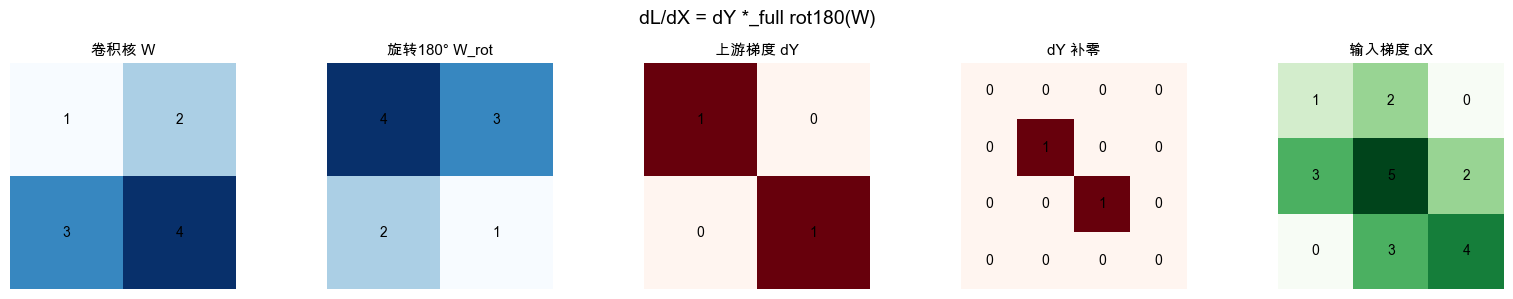


关键步骤：
1. 将卷积核 W 旋转 180°
2. 对上游梯度 dY 进行 padding（padding = kernel_size - 1）
3. 执行普通卷积


In [9]:
# ============================================================
# 可视化：输入梯度的计算过程
# ============================================================

def visualize_dX_computation():
    """
    可视化 dL/dX 的计算过程
    
    关键步骤：
    1. 将 W 旋转 180°
    2. 对 dY 进行 padding（padding = kernel_size - 1）
    3. 执行卷积
    """
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    
    # 卷积核 W (2x2)
    W = np.array([
        [1, 2],
        [3, 4]
    ])
    
    # 上游梯度 dY (2x2)
    dY = np.array([
        [1, 0],
        [0, 1]
    ])
    
    # 步骤1：旋转 W 180°
    W_rot = np.rot90(W, 2)
    
    # 步骤2：对 dY 进行 padding
    pad = W.shape[0] - 1  # = 1
    dY_padded = np.pad(dY, pad, mode='constant', constant_values=0)
    
    # 步骤3：卷积得到 dX
    out_h = dY_padded.shape[0] - W.shape[0] + 1  # = 3
    out_w = dY_padded.shape[1] - W.shape[1] + 1  # = 3
    dX = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            dX[i, j] = np.sum(dY_padded[i:i+2, j:j+2] * W_rot)
    
    # 绘制
    titles = ['卷积核 W', '旋转180° W_rot', '上游梯度 dY', 'dY 补零', '输入梯度 dX']
    matrices = [W, W_rot, dY, dY_padded, dX]
    cmaps = ['Blues', 'Blues', 'Reds', 'Reds', 'Greens']
    
    for ax, mat, title, cmap in zip(axes, matrices, titles, cmaps):
        ax.imshow(mat, cmap=cmap)
        ax.set_title(title, fontsize=11)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                ax.text(j, i, f'{mat[i,j]:.0f}', ha='center', va='center', fontsize=10)
        ax.axis('off')
    
    plt.suptitle('dL/dX = dY *_full rot180(W)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n关键步骤：")
    print("1. 将卷积核 W 旋转 180°")
    print("2. 对上游梯度 dY 进行 padding（padding = kernel_size - 1）")
    print("3. 执行普通卷积")

visualize_dX_computation()

### 2.4 对偏置 b 的梯度

偏置 b 是一个标量，被加到输出的每个位置。

$$Y[i, j] = \sum_{m} \sum_{n} X[i+m, j+n] \cdot W[m, n] + b$$

因此：
$$\frac{\partial Y[i, j]}{\partial b} = 1$$

应用链式法则：
$$\frac{\partial L}{\partial b} = \sum_{i} \sum_{j} \frac{\partial L}{\partial Y[i, j]} \cdot 1$$

$$\boxed{\frac{\partial L}{\partial b} = \sum_{i} \sum_{j} \frac{\partial L}{\partial Y[i, j]}}$$

**直觉**：偏置的梯度就是上游梯度的**总和**。

### 2.5 直觉理解：为什么梯度也是卷积？

这是一个很深刻的问题。让我们从直觉上理解：

#### 为什么 dW = X * dY？

```
卷积核 W[m,n] 在前向传播时：
- 与输入 X 的多个区域相乘
- 每次都贡献到不同的输出位置 Y[i,j]

反向传播时：
- 每个输出位置 Y[i,j] 的误差 dY[i,j] 都要分配给 W[m,n]
- 分配的权重就是当时 W[m,n] 乘以的输入值 X[i+m, j+n]
- 把所有贡献加起来 = 卷积操作！
```

#### 为什么 dX = dY * rot180(W)？

```
输入 X[i,j] 在前向传播时：
- 被卷积核的某个元素 W[m,n] 所使用
- 贡献到输出 Y[i-m, j-n]

反向传播时：
- 需要从 Y[i-m, j-n] 的误差 dY[i-m, j-n] 接收梯度
- 接收的权重就是 W[m,n]
- 但坐标变换 (i-m, j-n) 等价于与旋转后的核做卷积！
```

---

## 📐 3. 池化层梯度推导

池化层没有可学习的参数，但需要把梯度传给前一层。

### 3.1 最大池化的梯度

**前向传播**：选择窗口内的最大值

$$Y[i, j] = \max_{m, n} X[i \cdot s + m, j \cdot s + n]$$

**反向传播**：梯度只传给最大值所在的位置

$$\frac{\partial L}{\partial X[i', j']} = \begin{cases}
\frac{\partial L}{\partial Y[i, j]} & \text{如果 } X[i', j'] \text{ 是窗口内最大值} \\
0 & \text{否则}
\end{cases}$$

**直觉**：
- 只有"胜者"（最大值）对输出有贡献
- 所以梯度只传给"胜者"，其他位置梯度为 0

In [ ]:
# ============================================================
# 可视化：最大池化的梯度传递
# ============================================================

def visualize_maxpool_gradient():
    """
    可视化最大池化的梯度传递
    梯度只传给最大值的位置！
    """
    fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
    
    # 输入 (4x4)
    X = np.array([
        [1, 3, 2, 1],
        [4, 6, 5, 2],
        [7, 2, 8, 3],
        [1, 5, 4, 9]
    ])
    
    # 2x2 最大池化
    # 前向传播
    Y = np.array([
        [6, 5],  # max([1,3,4,6]), max([2,1,5,2])
        [7, 9]   # max([7,2,1,5]), max([8,3,4,9])
    ])
    
    # 上游梯度
    dY = np.array([
        [0.1, 0.2],
        [0.3, 0.4]
    ])
    
    # 反向传播：创建 mask 标记最大值位置
    dX = np.zeros_like(X, dtype=float)
    max_positions = [(1, 1), (1, 2), (2, 0), (3, 3)]  # 每个池化窗口的最大值位置
    dY_flat = dY.flatten()
    for idx, (i, j) in enumerate(max_positions):
        dX[i, j] = dY_flat[idx]
    
    # 绘制输入 X
    axes[0].imshow(X, cmap='Blues')
    axes[0].set_title('输入 X (4×4)', fontsize=12)
    for i in range(4):
        for j in range(4):
            color = 'red' if (i, j) in max_positions else 'black'
            weight = 'bold' if (i, j) in max_positions else 'normal'
            axes[0].text(j, i, f'{X[i,j]}', ha='center', va='center', 
                        fontsize=10, color=color, fontweight=weight)
    axes[0].axis('off')
    
    # 绘制池化输出 Y
    axes[1].imshow(Y, cmap='Blues')
    axes[1].set_title('MaxPool输出 Y (2×2)', fontsize=12)
    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, f'{Y[i,j]}', ha='center', va='center', fontsize=12)
    axes[1].axis('off')
    
    # 绘制上游梯度 dY
    axes[2].imshow(dY, cmap='Reds')
    axes[2].set_title('上游梯度 dY (2×2)', fontsize=12)
    for i in range(2):
        for j in range(2):
            axes[2].text(j, i, f'{dY[i,j]:.1f}', ha='center', va='center', fontsize=12)
    axes[2].axis('off')
    
    # 绘制输入梯度 dX
    axes[3].imshow(dX, cmap='Greens')
    axes[3].set_title('输入梯度 dX (4×4)', fontsize=12)
    for i in range(4):
        for j in range(4):
            axes[3].text(j, i, f'{dX[i,j]:.1f}', ha='center', va='center', fontsize=10)
    axes[3].axis('off')
    
    plt.suptitle('MaxPool梯度：只传给最大值位置（红色标记）', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_maxpool_gradient()

### 3.2 平均池化的梯度

**前向传播**：计算窗口内的平均值

$$Y[i, j] = \frac{1}{k^2} \sum_{m, n} X[i \cdot s + m, j \cdot s + n]$$

**反向传播**：梯度均匀分配到窗口内所有位置

$$\frac{\partial L}{\partial X[i', j']} = \frac{1}{k^2} \cdot \frac{\partial L}{\partial Y[i, j]}$$

**直觉**：
- 每个输入都对输出贡献了 $\frac{1}{k^2}$
- 所以每个输入都接收 $\frac{1}{k^2}$ 的梯度

In [ ]:
# ============================================================
# 对比：最大池化 vs 平均池化的梯度
# ============================================================

def compare_pool_gradients():
    """
    对比最大池化和平均池化的梯度传递方式
    """
    print("=" * 60)
    print("池化层梯度对比")
    print("=" * 60)
    
    # 输入窗口 (2x2)
    window = np.array([[1, 3], [2, 4]])
    
    # 上游梯度
    dY = 1.0
    
    print("\n输入窗口:")
    print(window)
    print(f"\n上游梯度 dY = {dY}")
    
    # 最大池化
    print("\n--- 最大池化 ---")
    print(f"前向：output = max(1, 3, 2, 4) = 4")
    dX_max = np.array([[0, 0], [0, 1]]) * dY
    print(f"反向：dX = ")
    print(dX_max)
    print("（梯度只传给最大值位置）")
    
    # 平均池化
    print("\n--- 平均池化 ---")
    print(f"前向：output = mean(1, 3, 2, 4) = 2.5")
    dX_avg = np.ones((2, 2)) * (dY / 4)
    print(f"反向：dX = ")
    print(dX_avg)
    print("（梯度均匀分配）")

compare_pool_gradients()

---

## 📐 4. ReLU 和 FC 层梯度

### 4.1 ReLU 的梯度

**前向传播**：
$$Y = \max(0, X)$$

**反向传播**：
$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \mathbf{1}_{X > 0}$$

其中 $\mathbf{1}_{X > 0}$ 是指示函数：
- 当 $X > 0$ 时为 1
- 当 $X \leq 0$ 时为 0

**直觉**：
- ReLU 在 $X > 0$ 时是恒等映射，梯度直接通过
- ReLU 在 $X \leq 0$ 时输出为 0，梯度被"杀死"

In [ ]:
# ============================================================
# ReLU 的前向和反向传播
# ============================================================

def demo_relu_gradient():
    """
    演示 ReLU 的梯度传递
    """
    print("ReLU 梯度演示")
    print("=" * 40)
    
    # 输入
    X = np.array([-2, -1, 0, 1, 2])
    
    # 前向传播
    Y = np.maximum(0, X)
    
    # 反向传播
    dY = np.array([1, 1, 1, 1, 1])  # 假设上游梯度全为1
    dX = dY * (X > 0).astype(float)
    
    print(f"输入 X:        {X}")
    print(f"输出 Y=ReLU(X): {Y}")
    print(f"上游梯度 dY:    {dY}")
    print(f"输入梯度 dX:    {dX}")
    print("\n规律：X > 0 的位置，梯度通过；X ≤ 0 的位置，梯度为 0")

demo_relu_gradient()

### 4.2 全连接层 (FC) 的梯度

**前向传播**：
$$Y = X \cdot W + b$$

其中：
- $X$：输入，形状 $(N, D_{in})$
- $W$：权重，形状 $(D_{in}, D_{out})$
- $b$：偏置，形状 $(D_{out},)$
- $Y$：输出，形状 $(N, D_{out})$

**反向传播**：

$$\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}$$

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T$$

$$\frac{\partial L}{\partial b} = \sum_{n=1}^{N} \frac{\partial L}{\partial Y[n, :]}$$

In [ ]:
# ============================================================
# FC 层的前向和反向传播
# ============================================================

def demo_fc_gradient():
    """
    演示全连接层的梯度计算
    """
    print("全连接层梯度演示")
    print("=" * 50)
    
    # 设置
    N = 2       # batch size
    D_in = 3    # 输入维度
    D_out = 2   # 输出维度
    
    # 输入和权重
    X = np.array([[1, 2, 3], [4, 5, 6]], dtype=float)  # (2, 3)
    W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]], dtype=float)  # (3, 2)
    b = np.array([0.1, 0.2], dtype=float)  # (2,)
    
    # 前向传播
    Y = X @ W + b  # (2, 2)
    
    print(f"输入 X (shape {X.shape}):")
    print(X)
    print(f"\n权重 W (shape {W.shape}):")
    print(W)
    print(f"\n偏置 b (shape {b.shape}): {b}")
    print(f"\n输出 Y = X @ W + b (shape {Y.shape}):")
    print(Y)
    
    # 反向传播
    dY = np.ones_like(Y)  # 假设上游梯度全为1
    
    dW = X.T @ dY        # (3, 2)
    dX = dY @ W.T        # (2, 3)
    db = dY.sum(axis=0)  # (2,)
    
    print("\n" + "=" * 50)
    print("反向传播")
    print("=" * 50)
    print(f"\n上游梯度 dY (shape {dY.shape}):")
    print(dY)
    print(f"\n权重梯度 dW = X.T @ dY (shape {dW.shape}):")
    print(dW)
    print(f"\n输入梯度 dX = dY @ W.T (shape {dX.shape}):")
    print(dX)
    print(f"\n偏置梯度 db = sum(dY, axis=0) (shape {db.shape}): {db}")

demo_fc_gradient()

---

## 💻 5. 从零实现各层反向传播

现在我们将上面的数学公式转化为代码。每一层都实现为一个类，包含 `forward` 和 `backward` 方法。

### 5.1 Conv 层类

In [10]:
# ============================================================
# 卷积层（带反向传播）
# ============================================================

class ConvLayer:
    """
    2D 卷积层（单通道简化版）
    
    前向传播：
        Y[i, j] = Σ_m Σ_n X[i+m, j+n] * W[m, n] + b
    
    反向传播：
        dW = X * dY（卷积）
        dX = dY *_full rot180(W)
        db = sum(dY)
    
    参数:
        kernel_size: 卷积核大小
    """
    
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        # 初始化权重（Xavier 初始化）
        # 使用较小的值初始化，防止梯度爆炸
        scale = np.sqrt(2.0 / (kernel_size * kernel_size))
        self.W = np.random.randn(kernel_size, kernel_size) * scale
        self.b = 0.0
        
        # 缓存（反向传播需要）
        self.X = None
        
        # 梯度
        self.dW = None
        self.db = None
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入，shape (H, W)
        
        返回:
            Y: 输出，shape (H-k+1, W-k+1)
        """
        # 保存输入（反向传播需要）
        self.X = X
        
        H, W_in = X.shape
        k = self.kernel_size
        
        # 输出尺寸
        out_h = H - k + 1
        out_w = W_in - k + 1
        
        # 卷积计算
        Y = np.zeros((out_h, out_w))
        for i in range(out_h):
            for j in range(out_w):
                # 提取感受野
                window = X[i:i+k, j:j+k]
                # 逐元素相乘求和
                Y[i, j] = np.sum(window * self.W) + self.b
        
        return Y
    
    def backward(self, dY):
        """
        反向传播
        
        参数:
            dY: 上游梯度，shape (out_h, out_w)
        
        返回:
            dX: 输入梯度，shape (H, W)
        """
        X = self.X
        H, W_in = X.shape
        k = self.kernel_size
        out_h, out_w = dY.shape
        
        # ========================================
        # 计算偏置梯度：db = sum(dY)
        # ========================================
        self.db = np.sum(dY)
        
        # ========================================
        # 计算权重梯度：dW = X * dY
        # dW[m, n] = Σ_i Σ_j dY[i, j] * X[i+m, j+n]
        # ========================================
        self.dW = np.zeros_like(self.W)
        for m in range(k):
            for n in range(k):
                # X 中对应的区域
                X_region = X[m:m+out_h, n:n+out_w]
                # 对应元素相乘求和
                self.dW[m, n] = np.sum(dY * X_region)
        
        # ========================================
        # 计算输入梯度：dX = dY *_full rot180(W)
        # ========================================
        # 步骤1：旋转 W 180°
        W_rot = np.rot90(self.W, 2)
        
        # 步骤2：对 dY 进行 padding
        pad = k - 1
        dY_padded = np.pad(dY, pad, mode='constant', constant_values=0)
        
        # 步骤3：卷积
        dX = np.zeros((H, W_in))
        for i in range(H):
            for j in range(W_in):
                window = dY_padded[i:i+k, j:j+k]
                dX[i, j] = np.sum(window * W_rot)
        
        return dX

In [11]:
# ============================================================
# 测试 ConvLayer
# ============================================================

def test_conv_layer():
    print("测试卷积层")
    print("=" * 50)
    
    # 创建卷积层
    conv = ConvLayer(kernel_size=3)
    
    # 输入
    X = np.random.randn(5, 5)
    
    # 前向传播
    Y = conv.forward(X)
    print(f"输入 X shape: {X.shape}")
    print(f"输出 Y shape: {Y.shape}")
    
    # 反向传播
    dY = np.ones_like(Y)
    dX = conv.backward(dY)
    print(f"\n上游梯度 dY shape: {dY.shape}")
    print(f"输入梯度 dX shape: {dX.shape}")
    print(f"权重梯度 dW shape: {conv.dW.shape}")
    print(f"偏置梯度 db: {conv.db:.4f}")

test_conv_layer()

测试卷积层
输入 X shape: (5, 5)
输出 Y shape: (3, 3)

上游梯度 dY shape: (3, 3)
输入梯度 dX shape: (5, 5)
权重梯度 dW shape: (3, 3)
偏置梯度 db: 9.0000


### 5.2 MaxPool 层类

In [12]:
# ============================================================
# 最大池化层（带反向传播）
# ============================================================

class MaxPoolLayer:
    """
    2D 最大池化层
    
    前向传播：
        Y[i, j] = max(窗口内所有值)
    
    反向传播：
        梯度只传给最大值的位置
    
    参数:
        pool_size: 池化窗口大小（默认2）
        stride: 步幅（默认等于pool_size）
    """
    
    def __init__(self, pool_size=2, stride=None):
        self.pool_size = pool_size
        self.stride = stride if stride else pool_size
        
        # 缓存
        self.X = None
        self.max_indices = None  # 记录最大值的位置
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入，shape (H, W)
        
        返回:
            Y: 输出，shape (H//pool_size, W//pool_size)
        """
        self.X = X
        H, W = X.shape
        p = self.pool_size
        s = self.stride
        
        # 输出尺寸
        out_h = (H - p) // s + 1
        out_w = (W - p) // s + 1
        
        Y = np.zeros((out_h, out_w))
        self.max_indices = []
        
        for i in range(out_h):
            for j in range(out_w):
                # 提取池化窗口
                i_start = i * s
                j_start = j * s
                window = X[i_start:i_start+p, j_start:j_start+p]
                
                # 找到最大值
                Y[i, j] = np.max(window)
                
                # 记录最大值在原始位置的索引（用于反向传播）
                max_idx = np.unravel_index(np.argmax(window), window.shape)
                self.max_indices.append((i_start + max_idx[0], j_start + max_idx[1]))
        
        return Y
    
    def backward(self, dY):
        """
        反向传播
        
        参数:
            dY: 上游梯度，shape (out_h, out_w)
        
        返回:
            dX: 输入梯度，shape (H, W)
        """
        H, W = self.X.shape
        dX = np.zeros((H, W))
        
        # 将梯度分配给最大值位置
        out_h, out_w = dY.shape
        idx = 0
        for i in range(out_h):
            for j in range(out_w):
                max_i, max_j = self.max_indices[idx]
                dX[max_i, max_j] += dY[i, j]
                idx += 1
        
        return dX

### 5.3 ReLU 层类

In [13]:
# ============================================================
# ReLU 激活层（带反向传播）
# ============================================================

class ReLULayer:
    """
    ReLU 激活函数
    
    前向传播：
        Y = max(0, X)
    
    反向传播：
        dX = dY * (X > 0)
    """
    
    def __init__(self):
        self.X = None
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入，任意形状
        
        返回:
            Y: 输出，与输入同形状
        """
        self.X = X
        return np.maximum(0, X)
    
    def backward(self, dY):
        """
        反向传播
        
        参数:
            dY: 上游梯度
        
        返回:
            dX: 输入梯度
        """
        # X > 0 的地方梯度通过，否则为 0
        return dY * (self.X > 0).astype(float)

### 5.4 FC 层类

In [14]:
# ============================================================
# 全连接层（带反向传播）
# ============================================================

class FCLayer:
    """
    全连接层
    
    前向传播：
        Y = X @ W + b
    
    反向传播：
        dW = X.T @ dY
        dX = dY @ W.T
        db = sum(dY, axis=0)
    
    参数:
        in_features: 输入维度
        out_features: 输出维度
    """
    
    def __init__(self, in_features, out_features):
        # Xavier 初始化
        scale = np.sqrt(2.0 / in_features)
        self.W = np.random.randn(in_features, out_features) * scale
        self.b = np.zeros(out_features)
        
        # 缓存
        self.X = None
        
        # 梯度
        self.dW = None
        self.db = None
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入，shape (N, in_features) 或 (in_features,)
        
        返回:
            Y: 输出，shape (N, out_features) 或 (out_features,)
        """
        # 处理单样本情况
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        self.X = X
        return X @ self.W + self.b
    
    def backward(self, dY):
        """
        反向传播
        
        参数:
            dY: 上游梯度
        
        返回:
            dX: 输入梯度
        """
        # 处理单样本情况
        if dY.ndim == 1:
            dY = dY.reshape(1, -1)
        
        self.dW = self.X.T @ dY
        self.db = dY.sum(axis=0)
        dX = dY @ self.W.T
        
        return dX

---

## 💻 6. 组装完整 CNN

### 6.1 SimpleCNN 类实现

现在我们把各层组装成一个完整的 CNN！

In [15]:
# ============================================================
# 完整的 CNN（从零实现）
# ============================================================

class SimpleCNN:
    """
    简单的 CNN（从零实现，包含反向传播）
    
    架构：
        输入 (28, 28)
        → Conv(3×3) → ReLU → MaxPool(2×2)  # → (13, 13)
        → Flatten                           # → (169,)
        → FC(169, 10)                       # → (10,)
    
    这是一个极简版本，用于教学演示。
    """
    
    def __init__(self):
        # 定义各层
        self.conv1 = ConvLayer(kernel_size=3)  # 28→26
        self.relu1 = ReLULayer()
        self.pool1 = MaxPoolLayer(pool_size=2)  # 26→13
        self.fc1 = FCLayer(13 * 13, 10)  # 169→10
        
        # 中间结果缓存
        self.cache = {}
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入图像，shape (28, 28)
        
        返回:
            logits: 类别分数，shape (10,)
        """
        # Conv → ReLU → Pool
        out = self.conv1.forward(X)       # (28,28) → (26,26)
        out = self.relu1.forward(out)     # (26,26)
        out = self.pool1.forward(out)     # (26,26) → (13,13)
        
        # 保存 pool 输出形状（用于反向传播的 reshape）
        self.cache['pool_shape'] = out.shape
        
        # Flatten
        out = out.flatten()               # (13,13) → (169,)
        
        # FC
        logits = self.fc1.forward(out)    # (169,) → (1, 10)
        
        return logits.squeeze()  # (10,)
    
    def backward(self, dlogits):
        """
        反向传播
        
        参数:
            dlogits: 损失对 logits 的梯度，shape (10,)
        
        返回:
            dX: 输入梯度（通常不需要）
        """
        # FC 反向
        dout = self.fc1.backward(dlogits)
        
        # Reshape 回 pool 输出形状
        dout = dout.reshape(self.cache['pool_shape'])
        
        # Pool → ReLU → Conv 反向
        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dX = self.conv1.backward(dout)
        
        return dX
    
    def update(self, lr):
        """
        更新权重（SGD）
        
        参数:
            lr: 学习率
        """
        # 更新 Conv 层
        self.conv1.W -= lr * self.conv1.dW
        self.conv1.b -= lr * self.conv1.db
        
        # 更新 FC 层
        self.fc1.W -= lr * self.fc1.dW
        self.fc1.b -= lr * self.fc1.db

In [16]:
# ============================================================
# 测试 SimpleCNN
# ============================================================

def test_simple_cnn():
    print("测试 SimpleCNN")
    print("=" * 50)
    
    # 创建网络
    cnn = SimpleCNN()
    
    # 随机输入（模拟 28×28 灰度图）
    X = np.random.randn(28, 28)
    
    # 前向传播
    logits = cnn.forward(X)
    print(f"输入 shape: (28, 28)")
    print(f"输出 logits shape: {logits.shape}")
    print(f"输出 logits: {logits}")
    
    # 反向传播（假设梯度全为1）
    dlogits = np.ones(10)
    dX = cnn.backward(dlogits)
    print(f"\n输入梯度 dX shape: {dX.shape}")
    
    # 更新权重
    cnn.update(lr=0.01)
    print("\n权重更新完成！")

test_simple_cnn()

测试 SimpleCNN
输入 shape: (28, 28)
输出 logits shape: (10,)
输出 logits: [ 1.09059869  4.16644812 -0.44673201 -0.54047763  3.3784772   1.86638709
  3.70316623  0.97264407  1.11501198  1.28201138]

输入梯度 dX shape: (28, 28)

权重更新完成！


### 6.2 梯度检验

为了验证我们的反向传播实现是否正确，我们用**数值梯度**来检验。

In [17]:
# ============================================================
# 梯度检验
# ============================================================

def gradient_check_conv():
    """
    对卷积层进行梯度检验
    
    方法：用数值梯度（中心差分）验证解析梯度
    """
    print("卷积层梯度检验")
    print("=" * 50)
    
    # 创建卷积层
    conv = ConvLayer(kernel_size=3)
    
    # 输入
    X = np.random.randn(5, 5)
    
    # 前向传播
    Y = conv.forward(X)
    
    # 定义损失函数：L = sum(Y^2)
    loss = np.sum(Y ** 2)
    
    # 解析梯度
    dY = 2 * Y  # dL/dY = 2Y
    conv.backward(dY)
    dW_analytical = conv.dW.copy()
    
    # 数值梯度（中心差分）
    eps = 1e-5
    dW_numerical = np.zeros_like(conv.W)
    
    for m in range(3):
        for n in range(3):
            # W[m,n] + eps
            conv.W[m, n] += eps
            Y_plus = conv.forward(X)
            loss_plus = np.sum(Y_plus ** 2)
            
            # W[m,n] - eps
            conv.W[m, n] -= 2 * eps
            Y_minus = conv.forward(X)
            loss_minus = np.sum(Y_minus ** 2)
            
            # 恢复
            conv.W[m, n] += eps
            
            # 数值梯度
            dW_numerical[m, n] = (loss_plus - loss_minus) / (2 * eps)
    
    # 比较
    print("解析梯度 dW:")
    print(dW_analytical)
    print("\n数值梯度 dW:")
    print(dW_numerical)
    
    # 相对误差
    rel_error = np.max(np.abs(dW_analytical - dW_numerical)) / (np.max(np.abs(dW_numerical)) + 1e-8)
    print(f"\n相对误差: {rel_error:.2e}")
    
    if rel_error < 1e-5:
        print("✓ 梯度检验通过！")
    else:
        print("✗ 梯度检验失败，请检查反向传播实现")

gradient_check_conv()

卷积层梯度检验
解析梯度 dW:
[[-40.77981402  -1.89750642 -10.68379518]
 [ -0.44392901  41.18619347   1.6754728 ]
 [  7.79765701  38.56331901 -19.77834362]]

数值梯度 dW:
[[-40.77981402  -1.89750642 -10.68379518]
 [ -0.44392901  41.18619347   1.6754728 ]
 [  7.79765701  38.56331901 -19.77834362]]

相对误差: 1.45e-11
✓ 梯度检验通过！


---

## 💻 7. 训练循环实现

现在让我们用自己实现的 CNN 在真实数据上训练！

### 7.1 交叉熵损失函数

In [18]:
# ============================================================
# Softmax 和交叉熵损失
# ============================================================

def softmax(x):
    """
    Softmax 函数
    
    将 logits 转换为概率分布
    
    参数:
        x: logits，shape (num_classes,)
    
    返回:
        probs: 概率，shape (num_classes,)，和为 1
    """
    # 减去最大值防止溢出
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)


def cross_entropy_loss(logits, target):
    """
    交叉熵损失函数
    
    参数:
        logits: 网络输出（未归一化），shape (num_classes,)
        target: 真实类别（整数）
    
    返回:
        loss: 损失值（标量）
        dlogits: 损失对 logits 的梯度，shape (num_classes,)
    """
    # 计算概率
    probs = softmax(logits)
    
    # 交叉熵损失
    # L = -log(probs[target])
    loss = -np.log(probs[target] + 1e-8)  # 加小量防止 log(0)
    
    # 梯度
    # dL/d(logits) = probs - one_hot(target)
    dlogits = probs.copy()
    dlogits[target] -= 1
    
    return loss, dlogits

In [19]:
# ============================================================
# 测试损失函数
# ============================================================

def test_loss():
    print("测试交叉熵损失函数")
    print("=" * 50)
    
    # 模拟网络输出（10类）
    logits = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
    target = 9  # 真实类别是 9
    
    # 计算损失和梯度
    loss, dlogits = cross_entropy_loss(logits, target)
    
    print(f"logits: {logits}")
    print(f"target: {target}")
    print(f"\nSoftmax 概率: {softmax(logits)}")
    print(f"\n损失 L = -log(P[target]): {loss:.4f}")
    print(f"\n梯度 dlogits: {dlogits}")

test_loss()

测试交叉熵损失函数
logits: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
target: 9

Softmax 概率: [7.80134161e-05 2.12062451e-04 5.76445508e-04 1.56694135e-03
 4.25938820e-03 1.15782175e-02 3.14728583e-02 8.55520989e-02
 2.32554716e-01 6.32149258e-01]

损失 L = -log(P[target]): 0.4586

梯度 dlogits: [ 7.80134161e-05  2.12062451e-04  5.76445508e-04  1.56694135e-03
  4.25938820e-03  1.15782175e-02  3.14728583e-02  8.55520989e-02
  2.32554716e-01 -3.67850742e-01]


### 7.2 准备 MNIST 数据

我们使用一个小型 MNIST 子集进行演示。

训练数据 shape: (200, 28, 28)
训练标签 shape: (200,)


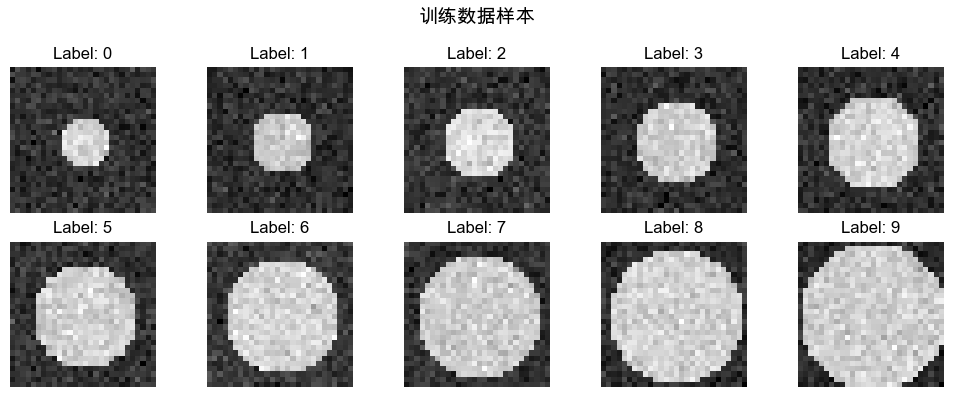

In [20]:
# ============================================================
# 准备 MNIST 数据（简化版）
# ============================================================

def generate_simple_data(num_samples=100):
    """
    生成简化的手写数字数据（用于演示）
    
    由于完整 MNIST 下载可能较慢，这里生成简化数据
    
    返回:
        X_train: 训练图像，shape (num_samples, 28, 28)
        y_train: 训练标签，shape (num_samples,)
    """
    X_train = []
    y_train = []
    
    for i in range(num_samples):
        label = i % 10
        
        # 创建简单的数字图案
        img = np.zeros((28, 28))
        
        # 根据标签画不同的图案
        center = 14
        radius = 5 + label  # 不同标签有不同大小
        
        for x in range(28):
            for y in range(28):
                if (x - center)**2 + (y - center)**2 < radius**2:
                    img[x, y] = 1.0
        
        # 添加噪声
        img += np.random.randn(28, 28) * 0.1
        
        X_train.append(img)
        y_train.append(label)
    
    return np.array(X_train), np.array(y_train)

# 生成数据
X_train, y_train = generate_simple_data(num_samples=200)
print(f"训练数据 shape: {X_train.shape}")
print(f"训练标签 shape: {y_train.shape}")

# 可视化几个样本
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.suptitle('训练数据样本', fontsize=14)
plt.tight_layout()
plt.show()

### 7.3 训练循环

In [21]:
# ============================================================
# 训练循环
# ============================================================

def train_cnn(X_train, y_train, epochs=10, lr=0.01):
    """
    训练 CNN
    
    参数:
        X_train: 训练图像，shape (N, 28, 28)
        y_train: 训练标签，shape (N,)
        epochs: 训练轮数
        lr: 学习率
    
    返回:
        cnn: 训练好的模型
        history: 训练历史
    """
    # 创建模型
    cnn = SimpleCNN()
    
    # 训练历史
    history = {'loss': [], 'accuracy': []}
    
    N = len(X_train)
    
    print("开始训练...")
    print("=" * 50)
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        
        # 打乱数据
        indices = np.random.permutation(N)
        
        for i in indices:
            X = X_train[i]
            y = y_train[i]
            
            # ========== 前向传播 ==========
            logits = cnn.forward(X)
            
            # ========== 计算损失 ==========
            loss, dlogits = cross_entropy_loss(logits, y)
            total_loss += loss
            
            # 计算准确率
            pred = np.argmax(logits)
            if pred == y:
                correct += 1
            
            # ========== 反向传播 ==========
            cnn.backward(dlogits)
            
            # ========== 更新权重 ==========
            cnn.update(lr)
        
        # 记录历史
        avg_loss = total_loss / N
        accuracy = correct / N * 100
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.1f}%")
    
    print("=" * 50)
    print("训练完成！")
    
    return cnn, history

# 训练模型
cnn, history = train_cnn(X_train, y_train, epochs=20, lr=0.01)

开始训练...
Epoch 1/20: Loss = 1.7359, Accuracy = 40.0%
Epoch 2/20: Loss = 0.4129, Accuracy = 98.0%
Epoch 3/20: Loss = 0.1314, Accuracy = 100.0%
Epoch 4/20: Loss = 0.0675, Accuracy = 100.0%
Epoch 5/20: Loss = 0.0441, Accuracy = 100.0%
Epoch 6/20: Loss = 0.0315, Accuracy = 100.0%
Epoch 7/20: Loss = 0.0244, Accuracy = 100.0%
Epoch 8/20: Loss = 0.0197, Accuracy = 100.0%
Epoch 9/20: Loss = 0.0164, Accuracy = 100.0%
Epoch 10/20: Loss = 0.0140, Accuracy = 100.0%
Epoch 11/20: Loss = 0.0122, Accuracy = 100.0%
Epoch 12/20: Loss = 0.0107, Accuracy = 100.0%
Epoch 13/20: Loss = 0.0095, Accuracy = 100.0%
Epoch 14/20: Loss = 0.0086, Accuracy = 100.0%
Epoch 15/20: Loss = 0.0078, Accuracy = 100.0%
Epoch 16/20: Loss = 0.0072, Accuracy = 100.0%
Epoch 17/20: Loss = 0.0065, Accuracy = 100.0%
Epoch 18/20: Loss = 0.0061, Accuracy = 100.0%
Epoch 19/20: Loss = 0.0057, Accuracy = 100.0%
Epoch 20/20: Loss = 0.0053, Accuracy = 100.0%
训练完成！


### 7.4 可视化训练过程

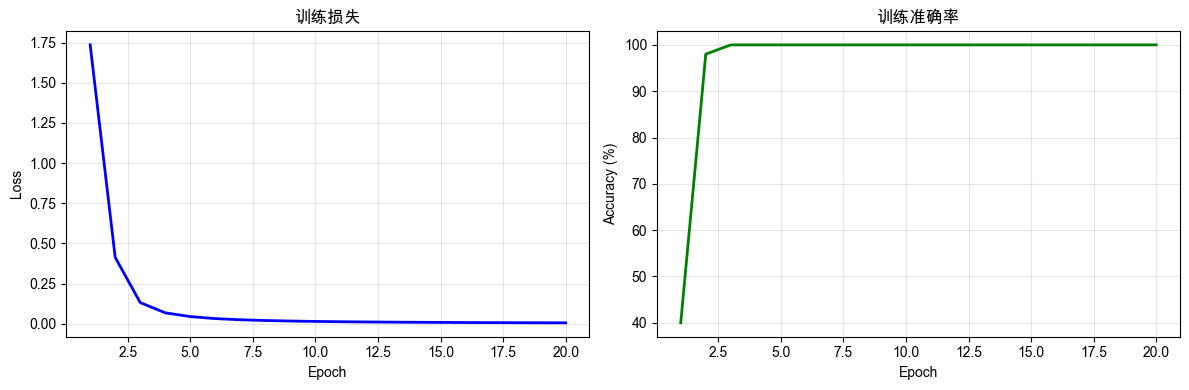

In [22]:
# ============================================================
# 可视化训练历史
# ============================================================

def plot_training_history(history):
    """
    绘制训练损失和准确率曲线
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['loss']) + 1)
    
    # 损失曲线
    axes[0].plot(epochs, history['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('训练损失')
    axes[0].grid(True, alpha=0.3)
    
    # 准确率曲线
    axes[1].plot(epochs, history['accuracy'], 'g-', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('训练准确率')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

---

## 🔍 8. 与 PyTorch 对比

### 8.1 PyTorch 如何自动计算梯度

PyTorch 使用 **autograd** 自动微分系统，不需要手写反向传播！

In [ ]:
# ============================================================
# PyTorch 自动求导演示
# ============================================================

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    print("PyTorch 自动求导演示")
    print("=" * 50)
    
    # 创建需要梯度的张量
    x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
    
    # 前向传播
    y = x ** 2
    z = y.sum()
    
    print(f"x = \n{x}")
    print(f"\ny = x^2 = \n{y}")
    print(f"\nz = sum(y) = {z.item()}")
    
    # 反向传播（自动！）
    z.backward()
    
    print(f"\ndz/dx = 2x = \n{x.grad}")
    print("\n注意：PyTorch 自动计算了梯度，无需手写反向传播！")
    
except ImportError:
    print("PyTorch 未安装，跳过此演示")
    print("安装命令：pip install torch")

### 8.3 用 PyTorch 重写 SimpleCNN

现在我们用 PyTorch 重新实现 SimpleCNN，对比两种方式的差异：

| 对比项 | NumPy 手写版 | PyTorch 版 |
|--------|-------------|------------|
| 前向传播 | 手动实现 forward() | 手动实现 forward() |
| 反向传播 | 手动实现 backward() | **自动！** loss.backward() |
| 权重更新 | 手动实现 update() | optimizer.step() |
| 代码量 | ~200 行 | ~20 行 |

In [ ]:
# ============================================================
# SimpleCNN 的 PyTorch 版本
# ============================================================

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim

    class SimpleCNN_PyTorch(nn.Module):
        """
        SimpleCNN 的 PyTorch 版本
        
        架构（与 NumPy 版本相同）：
            输入 (N, 1, 28, 28)
            → Conv(1→1, 3×3) → ReLU → MaxPool(2×2)  # → (N, 1, 13, 13)
            → Flatten                                # → (N, 169)
            → FC(169, 10)                            # → (N, 10)
        
        注意：这里用单通道是为了与 NumPy 版本对应
        实际应用中通常会用更多通道（如 32、64）
        """
        
        def __init__(self):
            super(SimpleCNN_PyTorch, self).__init__()
            
            # 卷积层：1个输入通道，1个输出通道，3×3 核
            self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=1,
                kernel_size=3,
                bias=True
            )
            
            # 池化层：2×2 最大池化
            self.pool1 = nn.MaxPool2d(kernel_size=2)
            
            # 全连接层
            # 28 → 26 (conv) → 13 (pool)
            # 展平后：1 × 13 × 13 = 169
            self.fc1 = nn.Linear(1 * 13 * 13, 10)
        
        def forward(self, x):
            """
            前向传播
            
            参数:
                x: 输入图像，shape (N, 1, 28, 28)
            
            返回:
                logits: 类别分数，shape (N, 10)
            """
            # Conv → ReLU → Pool
            x = self.conv1(x)       # (N, 1, 28, 28) → (N, 1, 26, 26)
            x = F.relu(x)           # (N, 1, 26, 26)
            x = self.pool1(x)       # (N, 1, 26, 26) → (N, 1, 13, 13)
            
            # Flatten
            x = x.view(x.size(0), -1)  # (N, 1, 13, 13) → (N, 169)
            
            # FC
            x = self.fc1(x)         # (N, 169) → (N, 10)
            
            return x
    
    # ========== 测试 ==========
    print("SimpleCNN PyTorch 版本")
    print("=" * 50)
    
    # 创建模型
    model = SimpleCNN_PyTorch()
    print(model)
    
    # 统计参数量
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n总参数量: {total_params}")
    
    # 测试前向传播
    x = torch.randn(1, 1, 28, 28)  # 单张图片
    logits = model(x)
    print(f"\n输入 shape: {x.shape}")
    print(f"输出 shape: {logits.shape}")
    print(f"输出 logits: {logits.detach().numpy().flatten()}")
    
except ImportError:
    print("PyTorch 未安装，跳过此部分")
    print("安装命令：pip install torch")

In [ ]:
# ============================================================
# PyTorch 训练循环（对比 NumPy 版本的简洁性）
# ============================================================

try:
    def train_pytorch_cnn(X_train, y_train, epochs=20, lr=0.01):
        """
        用 PyTorch 训练 SimpleCNN
        
        对比 NumPy 版本：
        - 无需手写 backward()
        - 无需手写 update()
        - 只需调用 loss.backward() 和 optimizer.step()
        """
        # 创建模型
        model = SimpleCNN_PyTorch()
        
        # 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        # 转换数据为 PyTorch 张量
        # NumPy: (N, 28, 28) → PyTorch: (N, 1, 28, 28)
        X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y_train, dtype=torch.long)
        
        history = {'loss': [], 'accuracy': []}
        
        print("PyTorch 训练开始...")
        print("=" * 50)
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct = 0
            
            # 遍历每个样本（简化版，实际应用应使用 DataLoader）
            for i in range(len(X_train)):
                x = X_tensor[i:i+1]  # (1, 1, 28, 28)
                y = y_tensor[i:i+1]  # (1,)
                
                # ========== 前向传播 ==========
                logits = model(x)
                loss = criterion(logits, y)
                
                # ========== 反向传播（自动！）==========
                optimizer.zero_grad()  # 清零梯度
                loss.backward()        # 自动计算所有梯度！
                
                # ========== 更新权重（自动！）==========
                optimizer.step()       # 自动更新所有参数！
                
                # 统计
                total_loss += loss.item()
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
            
            # 记录
            avg_loss = total_loss / len(X_train)
            accuracy = correct / len(X_train) * 100
            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            
            print(f"Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.1f}%")
        
        print("=" * 50)
        print("训练完成！")
        return model, history
    
    # 使用之前生成的数据训练
    model_pt, history_pt = train_pytorch_cnn(X_train, y_train, epochs=20, lr=0.01)
    
except NameError:
    print("请先运行前面的数据生成代码")
except Exception as e:
    print(f"错误: {e}")

### 8.4 NumPy vs PyTorch 代码对比

#### 反向传播对比

**NumPy 手写版（~50行）**：
```python
def backward(self, dlogits):
    # FC 反向
    dout = self.fc1.backward(dlogits)
    
    # Reshape
    dout = dout.reshape(self.cache['pool_shape'])
    
    # Pool → ReLU → Conv 反向
    dout = self.pool1.backward(dout)
    dout = self.relu1.backward(dout)
    dX = self.conv1.backward(dout)
    
    return dX

def update(self, lr):
    self.conv1.W -= lr * self.conv1.dW
    self.conv1.b -= lr * self.conv1.db
    self.fc1.W -= lr * self.fc1.dW
    self.fc1.b -= lr * self.fc1.db
```

**PyTorch 版（3行）**：
```python
optimizer.zero_grad()  # 清零梯度
loss.backward()        # 自动计算所有梯度！
optimizer.step()       # 自动更新所有参数！
```

#### 关键洞察

| 方面 | NumPy 手写 | PyTorch |
|------|-----------|---------|
| **学习价值** | 深入理解反向传播原理 | 快速上手实际项目 |
| **代码量** | 大量 | 极少 |
| **出错风险** | 高（容易写错梯度公式） | 低（自动求导） |
| **性能** | 较慢（纯 Python） | 快（C++ 后端 + GPU） |
| **适用场景** | 教学、研究新算法 | 实际生产应用 |

**结论**：
- 学习阶段：手写反向传播帮助理解原理
- 实际应用：使用 PyTorch/TensorFlow 等框架

### 8.2 验证我们的实现

In [ ]:
# ============================================================
# 对比 NumPy 实现和 PyTorch
# ============================================================

try:
    import torch
    import torch.nn.functional as F
    
    print("对比验证：NumPy vs PyTorch")
    print("=" * 50)
    
    # 相同的输入和卷积核
    X_np = np.random.randn(5, 5)
    W_np = np.random.randn(3, 3)
    
    # NumPy 实现
    conv_np = ConvLayer(kernel_size=3)
    conv_np.W = W_np.copy()
    conv_np.b = 0.0
    Y_np = conv_np.forward(X_np)
    
    # PyTorch 实现
    X_torch = torch.tensor(X_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,5,5)
    W_torch = torch.tensor(W_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,3,3)
    Y_torch = F.conv2d(X_torch, W_torch)
    Y_torch_np = Y_torch.squeeze().numpy()
    
    # 比较
    print("NumPy 卷积输出:")
    print(Y_np)
    print("\nPyTorch 卷积输出:")
    print(Y_torch_np)
    
    diff = np.max(np.abs(Y_np - Y_torch_np))
    print(f"\n最大差异: {diff:.2e}")
    
    if diff < 1e-5:
        print("✓ 验证通过！NumPy 实现与 PyTorch 一致")
    else:
        print("✗ 存在差异，请检查实现")
        
except ImportError:
    print("PyTorch 未安装，跳过对比验证")

---

## 📝 9. 本章小结

### 核心公式总结

| 层类型 | 权重梯度 dW | 输入梯度 dX | 偏置梯度 db |
|--------|------------|-------------|-------------|
| Conv | $X * dY$ | $dY *_{full} \text{rot180}(W)$ | $\sum dY$ |
| MaxPool | - | 只传给最大值位置 | - |
| AvgPool | - | $dY / k^2$ 均匀分配 | - |
| ReLU | - | $dY \cdot \mathbf{1}_{X>0}$ | - |
| FC | $X^T \cdot dY$ | $dY \cdot W^T$ | $\sum dY$ |

### 关键代码模式

```python
# 前向传播
def forward(self, X):
    self.X = X  # 保存输入（反向传播需要）
    Y = ...     # 计算输出
    return Y

# 反向传播
def backward(self, dY):
    self.dW = ...  # 计算权重梯度
    self.db = ...  # 计算偏置梯度
    dX = ...       # 计算输入梯度
    return dX      # 传给前一层
```

### 关键洞察

1. **卷积的反向传播也是卷积**：这使得 CNN 可以高效地在 GPU 上训练
2. **链式法则是关键**：梯度像水流一样从输出端流向输入端
3. **保存中间结果**：前向传播时保存的值在反向传播时需要用到

---

## 🎯 10. 练习题

完成以下练习，巩固本章所学内容。

### 练习1：手动计算卷积层梯度

给定：
- 输入 X = [[1, 2], [3, 4]]
- 卷积核 W = [[1, 0], [0, 1]]
- 上游梯度 dY = [[2]]

手动计算 dW 和 dX。

### 练习2：实现平均池化的反向传播

修改 MaxPoolLayer 类，实现 AvgPoolLayer。

### 练习3：添加更多卷积层

修改 SimpleCNN，添加第二个卷积层，观察训练效果。

---

## 🚀 下一步

学完本章后，你已经理解了 CNN 的完整训练过程！

接下来可以：
1. 完成 **exercise_cnn_mnist.py** - 用 PyTorch 实现完整的 MNIST 分类器
2. 继续学习 **07_classic_architectures.ipynb** - 经典 CNN 架构（LeNet、AlexNet、VGG、ResNet）